#Multi-objective Optimization Test Case - Kursawe Function
In this is example we will be solving the [Kursawe function](https://drive.google.com/file/d/1yiCQysLgRxc-MdeCbOTuMGkl3hadgS4f/view?usp=sharing) using NSGA 3. Kursawe is a popular test function used to test different multi-objective optimizations 

This is what the solution should look like ![Kursawe](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Kursawe_function.pdf/page1-796px-Kursawe_function.pdf.jpg)


###Step 1: Cloning the Project (House keeping)
Lets clone the test project in Glennopt. We will need the test folder located in `GlennOPT/test/kur/serial`

In [12]:
# Clone the source code for GlennOPT
!git clone https://github.com/nasa/GlennOPT.git
# Little Housekeeping
!cp -r GlennOPT/test/KUR/serial/Evaluation .    # Copy the folder we need 
!rm GlennOPT/ -r        # Deletes GlennOPT source code. We don't need this anymore

Cloning into 'GlennOPT'...
remote: Enumerating objects: 43967, done.
remote: Counting objects: 100% (43298/43298), done.
remote: Compressing objects: 100% (24447/24447), done.
remote: Total 43967 (delta 14024), reused 41811 (delta 12569), pack-reused 669
Receiving objects: 100% (43967/43967), 22.58 MiB | 15.03 MiB/s, done.
Resolving deltas: 100% (14403/14403), done.
Checking out files: 100% (33022/33022), done.


In [ ]:
# Install GlennOPT 
!python --version
!pip install glennopt
# Restart the runtime
import os
os.kill(os.getpid(), 9)

Python 3.7.12


#Folder Structure and Evaluation Script

###Initial folder structure
```
Evaluation
| - evaluate.py     (Gets copied to each individual directory)
multi-objective_example.ipynb
machinefile.txt (Optional, add this if you want to breakdown hosts per evaluation)
```

###After optimization
```
Calculation
| - DOE
| -- IND000
| ----- input.txt   (Generated by optimizer)
| ----- evaluate.py (Executes the cfd and reads results)
| ----- output.txt  (Generated by evaluate.py)
| -- ...
| -- IND128
| - POP000
| -- IND000
| -- ...
| -- IND039
Evaluation
| - evaluate.py     (Gets copied to each individual directory)
multi-objective_example.ipynb
machinefile.txt (Optional, add this if you want to break down hosts per evaluation)
```
Note: Glennopt constructs the calculation folder automatically. Each population is saved as DOE or as POPXXX. This is done so that when you are running a Computational Fluid Simulation or any kind of optimization where crashes could occur, you can investigate why the simulation crashed.

Also if there are any additional post processing that needs to be done, by saving the evaluations this way, it is also possible to re-process the files differently and restart the optimization. **Restarts** will be shown in a later section.


##Evaluation Script
You may have noticed that when in earler codes the github folder is cloned and part of it was copied and the rest of it was deleted. This is done to import the evaluation script found in Evaluation/evaluate.py

The purpose of this script is to call the Kursawe function (kur.py) to perform a single execution. The inputs will be read from an input.dat file and output to output.txt. See `read_input` and `print_output` functions

---
```
# evaluation.py
def read_input(input_filename):
    x = []
    with open(input_filename, "r") as f: 
        for line in f:
            split_val = line.split('=')
            if len(split_val)==2: # x1 = 2 # Grab the 2
                x.append(float(split_val[1]))
    return x
 
def print_output(y):
    with open("output.txt", "w") as f:        
        f.write('objective1 = {0:.6f}\n'.format(y[0])) # Output should contain [Name of the Objective/Parameter] = [value] This is read by the optimizer 
        f.write('objective2 = {0:.6f}\n'.format(y[1]))
        f.write('p1 = {0:.6f}\n'.format(y[2]))
        f.write('p2 = {0:.6f}\n'.format(y[3]))
        f.write('p3 = {0:.6f}\n'.format(y[4]))
        # f.write('Objective2 = {0:.6f}\n'.format(y))
 
if __name__ == '__main__':
    x = read_input("input.dat")
    # Call Rosebrock test function 
    import kur as kur
    y = kur.KUR(x[0],x[1],x[2])
    print_output(y)
```
## Kursawe Function
This is the kursawe function copied from wikipedia
```
# kur.py
import math

def KUR(x1,x2,x3):
    '''
        Kursawe Function
        mutiple output
    '''
    f1 = (-10*math.exp(-0.2*math.sqrt(x1*x1+x2*x2))) + (-10*math.exp(-0.2*math.sqrt(x2*x2+x3*x3)))

    f2 = (math.pow(abs(x1),0.8)+5*math.sin(x1*x1*x1))+(math.pow(abs(x2),0.8)+5*math.sin(x2*x2*x2))+(math.pow(abs(x3),0.8)+5*math.sin(x3*x3*x3))
    # Performance Parameter
    p1 = x1 + x2 + x3
    p2 = x1*x2*x3
    p3 = x1 - x2 - x3
    return f1,f2,p1,p2,p3
```




#Optimization

Import relevant libraries

In [1]:
import sys,os
from glennopt.base import Parameter
from glennopt.helpers import mutation_parameters, de_mutation_type
from glennopt.optimizers import NSGA3
from glennopt.DOE import Default,CCD,FullFactorial,LatinHyperCube

In [2]:
# Clean up
!rm -r Calculation  # Remove the calculation folder, lets start from scratch
!rm *.csv *.log     # Remove the restart file and any log files generated

rm: cannot remove '*.log': No such file or directory


**Evaluation Parameters**: are required. This is the vector of variables that goes into your objective function.

**Objectives**: number of objectives to solve for

**Performance Parameters**: this is not required but I set this up for reference

In [3]:
# Initialize the DOE
# doe = CCD()
doe = FullFactorial(levels=8)
# doe = LatinHyperCube(128)

doe.add_parameter(name="x1",min_value=-5,max_value=5)
doe.add_parameter(name="x2",min_value=-5,max_value=5)
doe.add_parameter(name="x3",min_value=-5,max_value=5)

doe.add_objectives(name='objective1')
doe.add_objectives(name='objective2')

# No performance Parameters
doe.add_perf_parameter(name='p1')
doe.add_perf_parameter(name='p2')
doe.add_perf_parameter(name='p2')


In [4]:
# Initialize the Optimizer
pop_size=32
current_dir = os.getcwd()
ns = NSGA3(eval_command = "python evaluation.py", eval_folder="Evaluation",pop_size=pop_size,optimization_folder=current_dir)

ns.add_objectives(objectives=doe.objectives)
ns.add_eval_parameters(eval_params=doe.eval_parameters)
ns.add_performance_parameters(performance_params= doe.perf_parameters)

**If you want other mutaton strategies or crossover strategies just add an issue to the github and provide as many references and examples as possible. We will try to incorporate them. **

In [5]:
# Set the mutation parameters
ns.mutation_params.mutation_type = de_mutation_type.de_rand_1_bin   # Choice of de_best_1_bin (single objective) or de_rand_1_bin (multi-objective)
ns.mutation_params.F = 0.8
ns.mutation_params.C = 0.7

# Parallel Settings (You don't need to run this block if you only want serial execution)
ns.parallel_settings.concurrent_executions = 8    # Change to 1 for serial
ns.parallel_settings.cores_per_execution = 1    
ns.parallel_settings.execution_timeout = 0.2      # minutes

Enable Parallel Execution (OPTIONAL) 

In [6]:
# Parallel Settings (You don't need to run this block if you only want serial execution)
ns.parallel_settings.concurrent_executions = 8    # Change to 1 for serial
ns.parallel_settings.cores_per_execution = 1    
ns.parallel_settings.execution_timeout = 0.2      # minutes

##Run the Design of Experiments
Design of experiments is used to sample the evaluation space. Say you have 5 variables and f(x[1-5]) = y[1,2] and each x1 through x5 have min and max bounds. The design of experiments is used to evaluate different combinations of x1 to x5 which are used as the starting population (pop_start=-1) 

In [7]:
# Generate the DOE and start the optimization
ns.start_doe(doe.generate_doe())

100%|██████████| 512/512 [00:00<00:00, 15385.44it/s]


In [8]:
# Execute the Optimization
ns.optimize_from_population(pop_start=-1,n_generations=25)    # Start from the DOE and iterate from pop 0 to 24

###Restarting the Simulation from a previous restart file


In [ ]:
ns.optimize_from_population(pop_start=24,n_generations=25)    # Start from the DOE and iterate from pop 24 to 49

##Generating a restart file
Just in case you accidentally deleted it

In [9]:
!rm restart_file.csv
ns.create_restart() # Appends/creates a new restart file

##Plotting the Pareto Front





You can make the plots using the glennopt or you can create animated plots of the pareto front

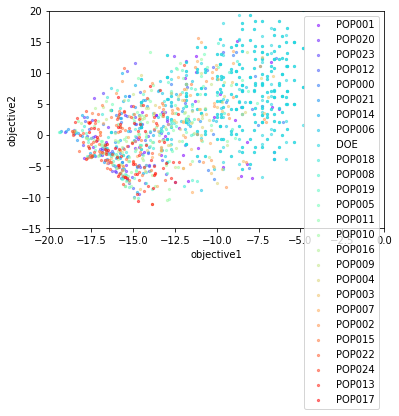

In [10]:
ns.read_calculation_folder()
ns.plot_2D('objective1','objective2',[-20,0],[-15,20])

###Animated Plot
This is an example of an animated plot. It may take a while to run depending on the number of frames and the interval

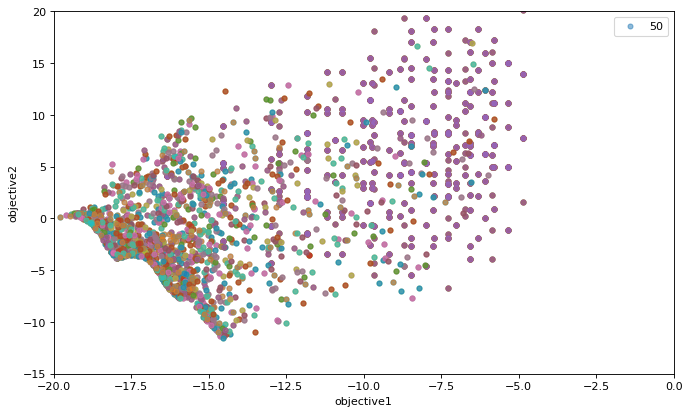

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np

num_frames = 150

xlim = [-20,0]
ylim = [-15,20]
obj1_name = 'objective1'
obj2_name = 'objective2'

ns.read_calculation_folder()

fig,ax = plt.subplots(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k')

keys = list(ns.pandas_cache.keys())
keys.sort()
nPop = len(list(ns.pandas_cache.keys()))
divisor = num_frames/nPop
def init():  
  data = get_data(0)
  pop_scatter = ax.scatter(data[:,0],data[:,1],s=20,alpha=0.5)
  ax.set_xlim(xlim[0],xlim[1])
  ax.set_ylim(ylim[0],ylim[1])  
  ax.set_xlabel(obj1_name)
  ax.set_ylabel(obj2_name)
  #pop_scatter.set_array(np.array([]))
  return pop_scatter,

def get_data(pop):  
  key = keys[pop]
  obj_data = list()
  for index, row in ns.pandas_cache[key].iterrows():
    obj_data.append([row[obj1_name],row[obj2_name]])
  return np.array(obj_data)

def animate(pop):
  pop = int(pop/divisor)
  data = get_data(pop)
  pop_scatter = ax.scatter(data[:,0],data[:,1],s=20,alpha=0.5)  
  ax.legend([str(pop)])
  return pop_scatter,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=num_frames, interval=10, blit=True)
HTML(anim.to_html5_video())

#Visualization


Getting the best objective value vs population. This is useful to see if the objective is changing as population increases

In [ ]:
from glennopt.base import Individual
from glennopt.helpers import get_best,get_pop_best
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

individuals = ns.read_calculation_folder()

best_individuals, best_fronts = get_pop_best(individuals)
# pop size is the size of population to keep track of when applying non-dimensional sorting. Larger the size = greater the slow down
objectives, pop, best_fronts = get_best(individuals,pop_size=30) 
print(objectives.shape)

Running Non-dimensional sorting: 100%|██████████| 51/51 [00:26<00:00,  1.89it/s]

(51, 2)


## Plotting the best objective vs population

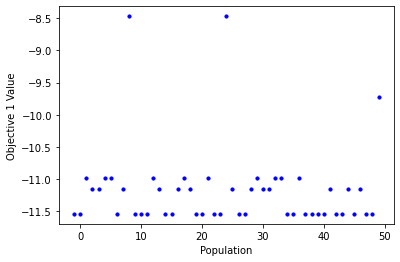

In [ ]:
objective_index = 1
_, ax = plt.subplots()    
ax.scatter(pop, objectives[:,objective_index],color='blue',s=10)
ax.set_xlabel('Population')
ax.set_ylabel('Objective {0} Value'.format(objective_index))
plt.show()

#Plotting the best individual in each population

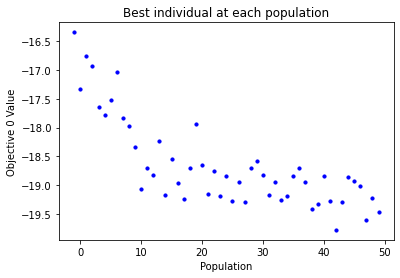

In [ ]:
nobjectives = len(best_individuals[0][0].objectives)
objective_data = list()
for pop,best_individual in best_individuals.items():
    objective_data.append(best_individual[objective_index].objectives[objective_index])

_,ax = plt.subplots()
colors = cm.rainbow(np.linspace(0, 1, len(best_individuals.keys())))
ax.scatter(list(best_individuals.keys()), objective_data, color='blue',s=10)
ax.set_xlabel('Population')
ax.set_ylabel('Objective {0} Value'.format(objective_index))
ax.set_title('Best individual at each population')
plt.show()

##Plot the Pareto Front
The pareto front shows a trade off between two objective values. As the optimization advances to the next population, the individuals get closer to the minimum of both objectives and yields designs that are a compromise between the two. 

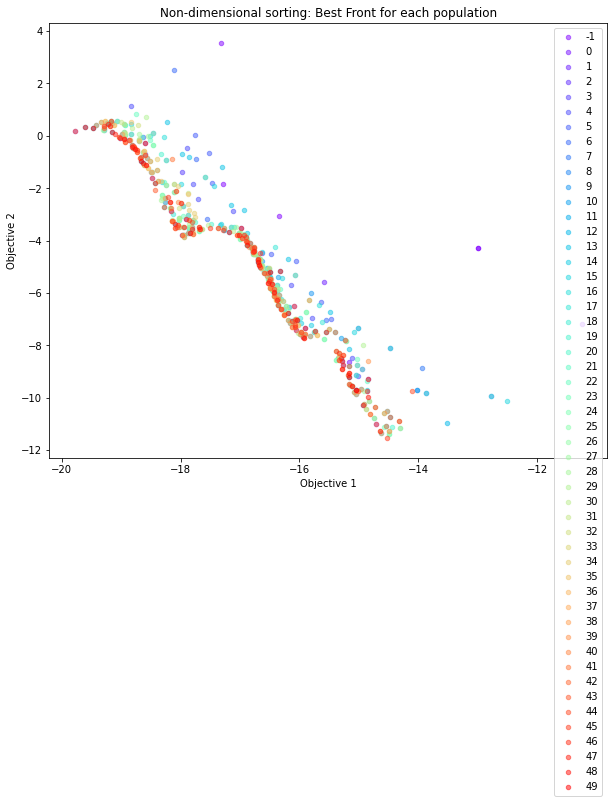

In [ ]:
best_fronts = [front for _,front in sorted(zip(pop,best_fronts))]   # dictionary keys aren't sorted. this cleans up some stuff. 
pop = sorted(pop)

fig,ax = plt.subplots(figsize=(10,8))

colors = cm.rainbow(np.linspace(0, 1, len(best_fronts)))        
indx = 0
legend_labels = []
# Scan the pandas file, grab objectives for each population
for ind_list in best_fronts:
    obj1_data = []
    obj2_data = []
    c=colors[indx]
    for ind in ind_list[0]:
        obj1_data.append(ind.objectives[0])
        obj2_data.append(ind.objectives[1])
    # Plot the gathered data
    ax.scatter(obj1_data, obj2_data, color=c, s=20,alpha=0.5)
    legend_labels.append(pop[indx])
    indx+=1

ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_title('Non-dimensional sorting: Best Front for each population')
ax.legend(legend_labels)
fig.canvas.draw()
fig.canvas.flush_events()
plt.show()